# Changes in Suicide Rates (United States, 1980-2018)
#### Chris Cooper 115573833

### Imports

In [1]:
import numpy as np
import sklearn as sk
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

### Data
This data was retrieved from [Data.gov](https://data.gov), more specifically [this](https://catalog.data.gov/dataset/death-rates-for-suicide-by-sex-race-hispanic-origin-and-age-united-states-020c1) dataset on suicide rates in the United States, grouped by year. It includes a couple selected population characteristics, namely age, sex, race, and Hispanic origin. In this tutorial however, we will see primarily how different age groups affect suicide rates.

First things first, the data has been retrieved and will be imported as a csv. This is then inserted via pandas into a dataframe for convenience.

In [2]:
path = 'Data.csv'
data = pd.read_csv(path)

### Cleaning
Next, we will remove missing data from the estimate column; rows without an estimated suicide rate, which have no use to us. Other superfluous columns are also removed. This dataset was pretty tidy, however looking over the missing data, it is clear that the formatting for gathering the data was not standardized throughout the years, or was not collected one way or another for some years. More specifically, race and Hispanic origin had more empty estimates that will be removed, so these findings may be less accurate/more skewed, as the reasoning behind their missingness is not known. 

However, since there is a clear pattern to what data is missing, I would describe the missingness of this data as MNAR (Missing Not At Random).

These issues are more prevalant for the early years that are included (1950, 1960, 1970), so these years I will remove to try and get a more accurate result. This is also likely a good decision as the data was not collected yearly until 1980, and leaves big gaps in the charts.

In [3]:
data = data.dropna(subset=['ESTIMATE'])

In [4]:
data = data.drop(columns=['FLAG', 'INDICATOR', 'YEAR_NUM'])

In [5]:
drop_years = [1950, 1960, 1970]
data = data[~data['YEAR'].isin(drop_years)]

In [6]:
data.head()

,UNIT,UNIT_NUM,STUB_NAME,STUB_NAME_NUM,STUB_LABEL,STUB_LABEL_NUM,YEAR,AGE,AGE_NUM,ESTIMATE
3,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1980,All ages,0.0,12.2
4,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1981,All ages,0.0,12.3
5,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1982,All ages,0.0,12.5
6,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1983,All ages,0.0,12.4
7,"Deaths per 100,000 resident population, age-ad...",1,Total,0,All persons,0.0,1984,All ages,0.0,12.6


Here is an example of the dataset. The first two columns are indicators of what kind of estimate is being made, either with age factored in already or not. I will use the non-factored data (crude) to analyze the effect age has on suicide rate, then later we will extract the age-adjusted data to look at race.

In [7]:
# Create a clean column with only age groups in it, since we can assume age 
# is a large factor and do not want to have a cumulative inside our data
data['AGE_GROUPS'] = data['AGE'].apply(lambda x: x if x != "All ages" else None)

# Create a filtered dataframe for ease of use. We want crude ('UNIT_NUM' = 2), 
# age-only ('STUB_NAME_NUM' = 2) data 
filtered_df = data[(data['AGE'] != "All ages") & (data['UNIT_NUM'] == 2) & (data['STUB_NAME_NUM'] == 1)]

# Unneccesary now that we have selected the data that we want from the original data
filtered_df = filtered_df.drop(columns = ['UNIT', 'UNIT_NUM', 'STUB_NAME_NUM'])

In [8]:
# Create a helper dataframe to hold the mean estimate rate per year
df = filtered_df.groupby('YEAR')['ESTIMATE'].mean().reset_index()
df.rename(columns={'ESTIMATE': 'ESTIMATE_M'}, inplace=True)

In [9]:
# Create a normalized dataframe of the data
merged_df = filtered_df.merge(df, on='YEAR', how='left')
min_value = merged_df['ESTIMATE'].min()
max_value = merged_df['ESTIMATE'].max()
merged_df['CENTER_ESTIMATE'] = merged_df['ESTIMATE'] - merged_df['ESTIMATE_M']
merged_df['SCALED_ESTIMATE'] = (merged_df['ESTIMATE'] - min_value) / (max_value - min_value)

### Observations
Now lets plot the data and see how it looks

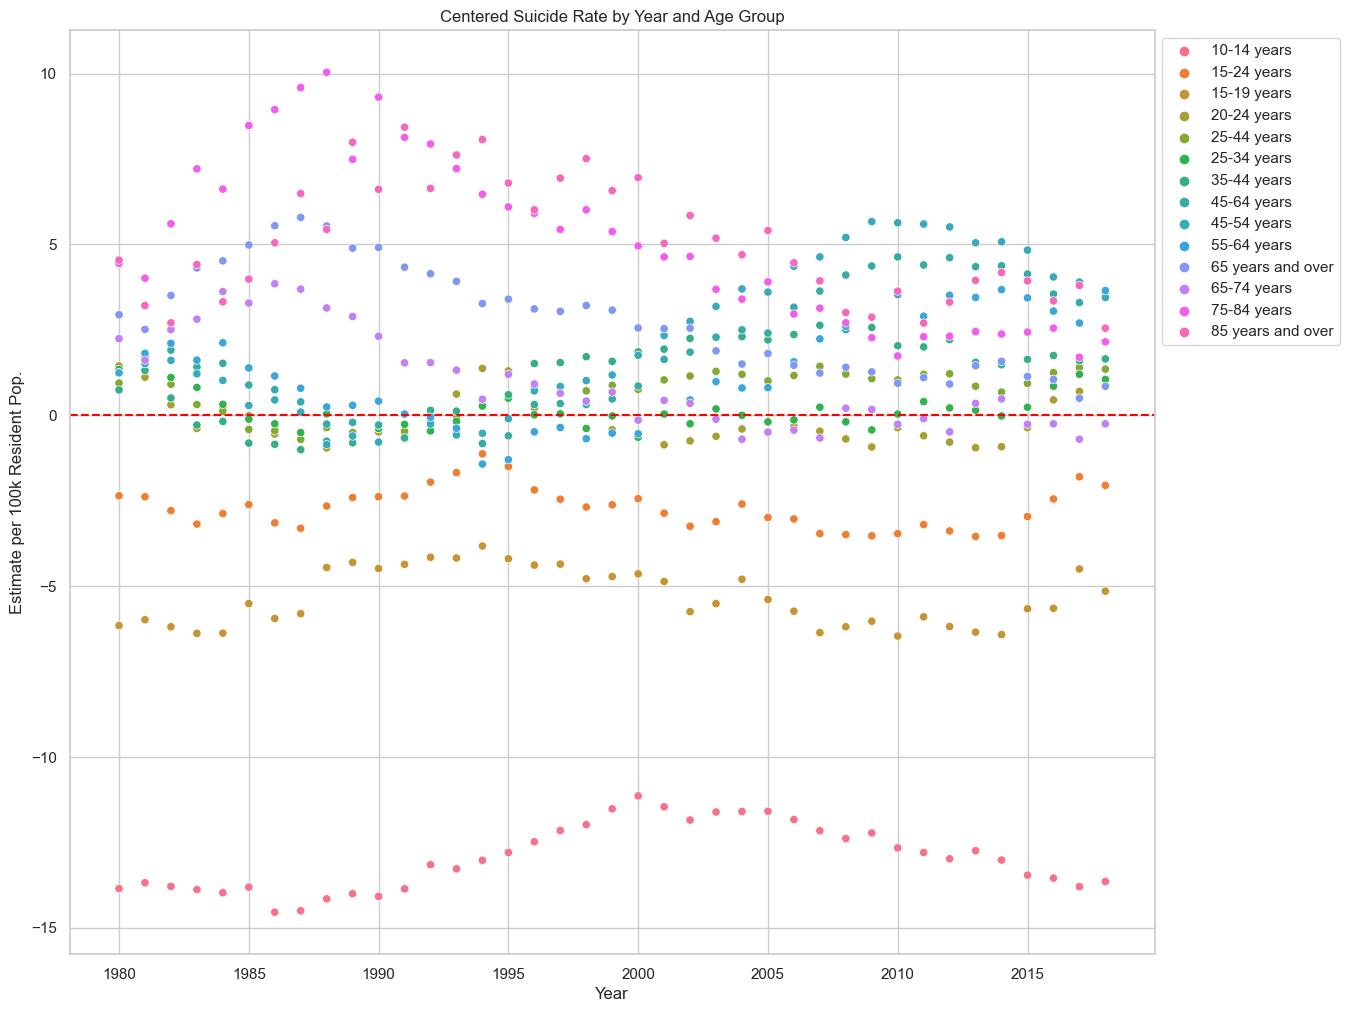

In [10]:
# Plotting the centered data
sns.set(style="whitegrid")


plt.figure(figsize=(14, 12))
sns.scatterplot(data=merged_df, x='YEAR', y='CENTER_ESTIMATE', hue='AGE_GROUPS')
plt.axhline(y=0, color='red', linestyle='--') # Center line
plt.xlabel('Year')
plt.ylabel('Estimate per 100k Resident Pop.')
plt.title('Centered Suicide Rate by Year and Age Group')

plt.legend(title='Age Group')

plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

Looking at the plot, it is clear certain groups have much different baselines. Younger groups tend to be below, or much below, the average, and older groups tend to be above average. This will show up later.

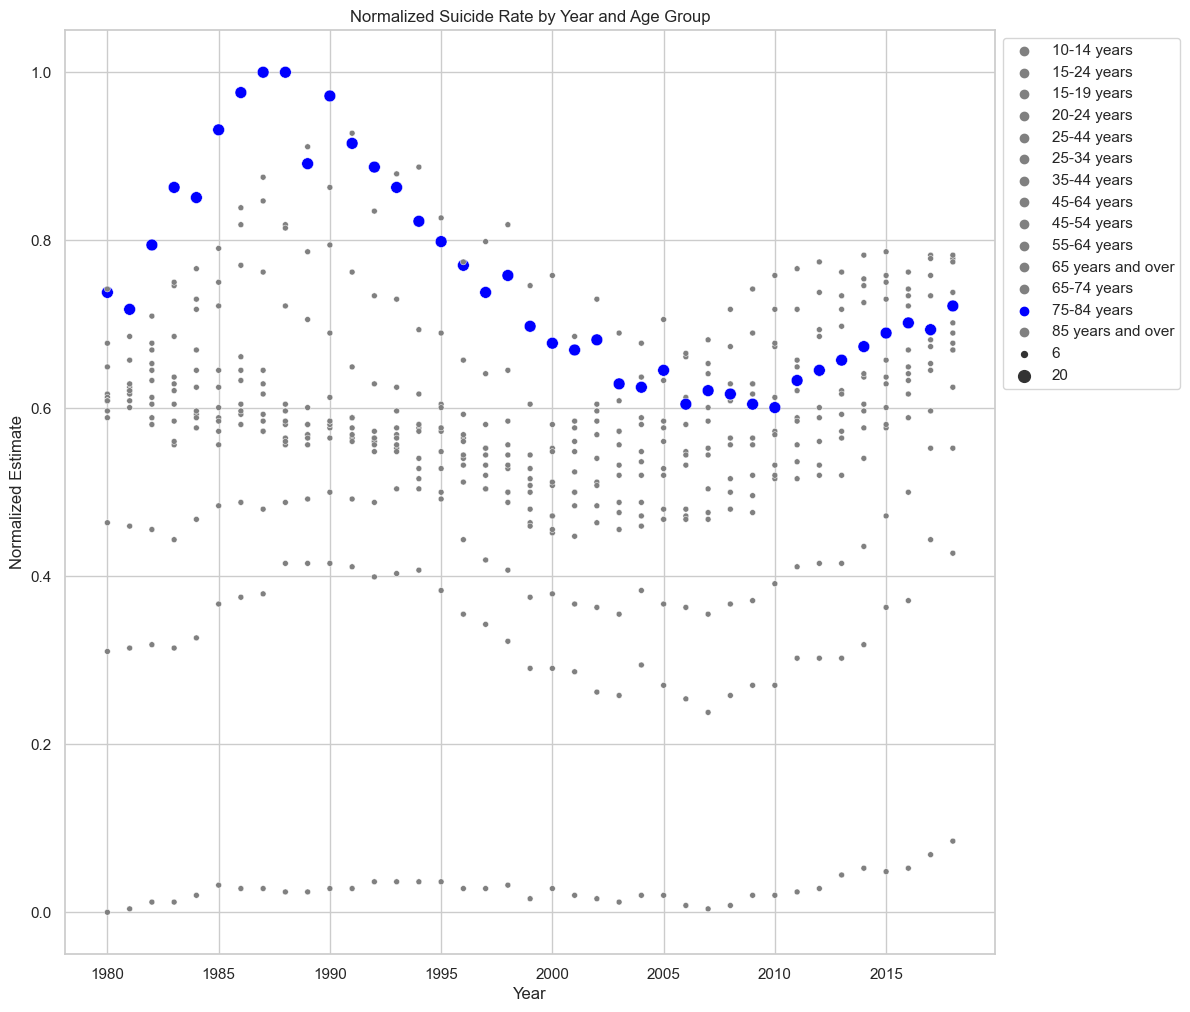

In [11]:
# Plotting 75-84 year olds highlighted, on an age-normalized plot
plt.figure(figsize=(12, 12))
color_palette = ['grey' if group != '75-84 years' else 'blue' for group in merged_df['AGE_GROUPS'].unique()]
sizes = [20 if group == '75-84 years' else 6 for group in merged_df['AGE_GROUPS']]
sns.scatterplot(data=merged_df, x='YEAR', y='SCALED_ESTIMATE', hue='AGE_GROUPS', palette=color_palette, size=sizes)

plt.xlabel('Year')
plt.ylabel('Normalized Estimate')
plt.title('Normalized Suicide Rate by Year and Age Group')
plt.legend(title='Age Group')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.show()

Here is a highlighting of the 75-84 year old grouping, to make it more obvious. The lowest group on the chart is the 10-14 year olds, whos estimate is much lower, however the rising and falling through the years seems somewhat consistant. 

This is likely due to other factors happening during the years, but I could not see well-known tramatic events affecting the charts. For example, the economic crash in 2008 does not see a drastic rise in suicide rate, in fact looking at the violin plots later it appears average. 2000 and 2001 see the biggest dip in every group.

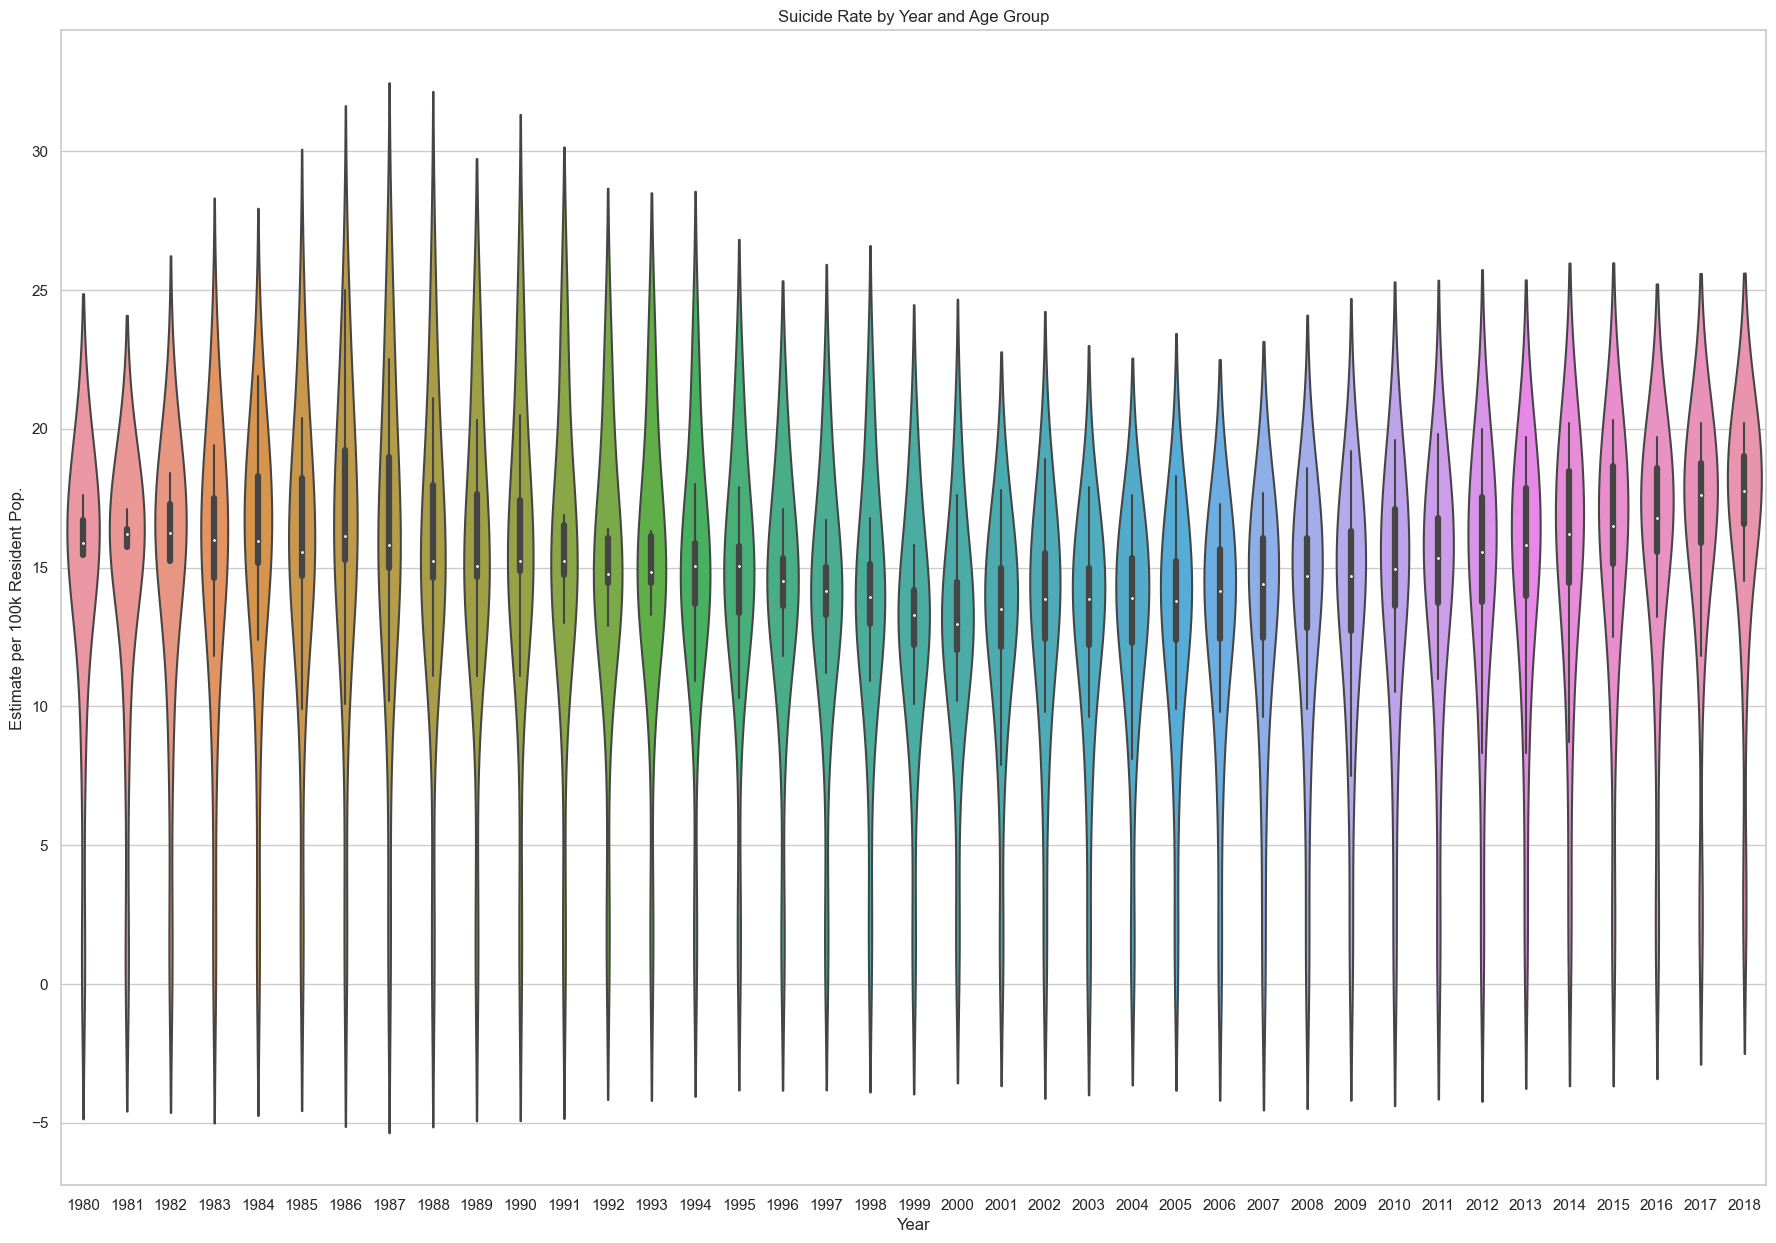

In [12]:
# Violin plot

plt.figure(figsize=(22, 15))
sns.violinplot(data=filtered_df, x='YEAR', y='ESTIMATE')
plt.xlabel('Year')
plt.ylabel('Estimate per 100k Resident Pop.')
plt.title('Suicide Rate by Year and Age Group')

plt.show()

Looking at the bandwith of the violin plot, there is a lot of "stretching", meaning there are certain group(s) that have a higher/lower than average suicide rate, which is what we saw before.


## Learning
Lets see how a linear model of the estimate and year fits, with an interaction term of the age group and the year.

In [13]:
model = smf.ols(formula="ESTIMATE ~ YEAR + AGE:YEAR", data=filtered_df).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:               ESTIMATE   R-squared:                       0.860
Model:                            OLS   Adj. R-squared:                  0.856
Method:                 Least Squares   F-statistic:                     232.6
Date:                Sun, 20 Aug 2023   Prob (F-statistic):          6.38e-216
Time:                        20:48:06   Log-Likelihood:                -1093.3
No. Observations:                 546   AIC:                             2217.
Df Residuals:                     531   BIC:                             2281.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

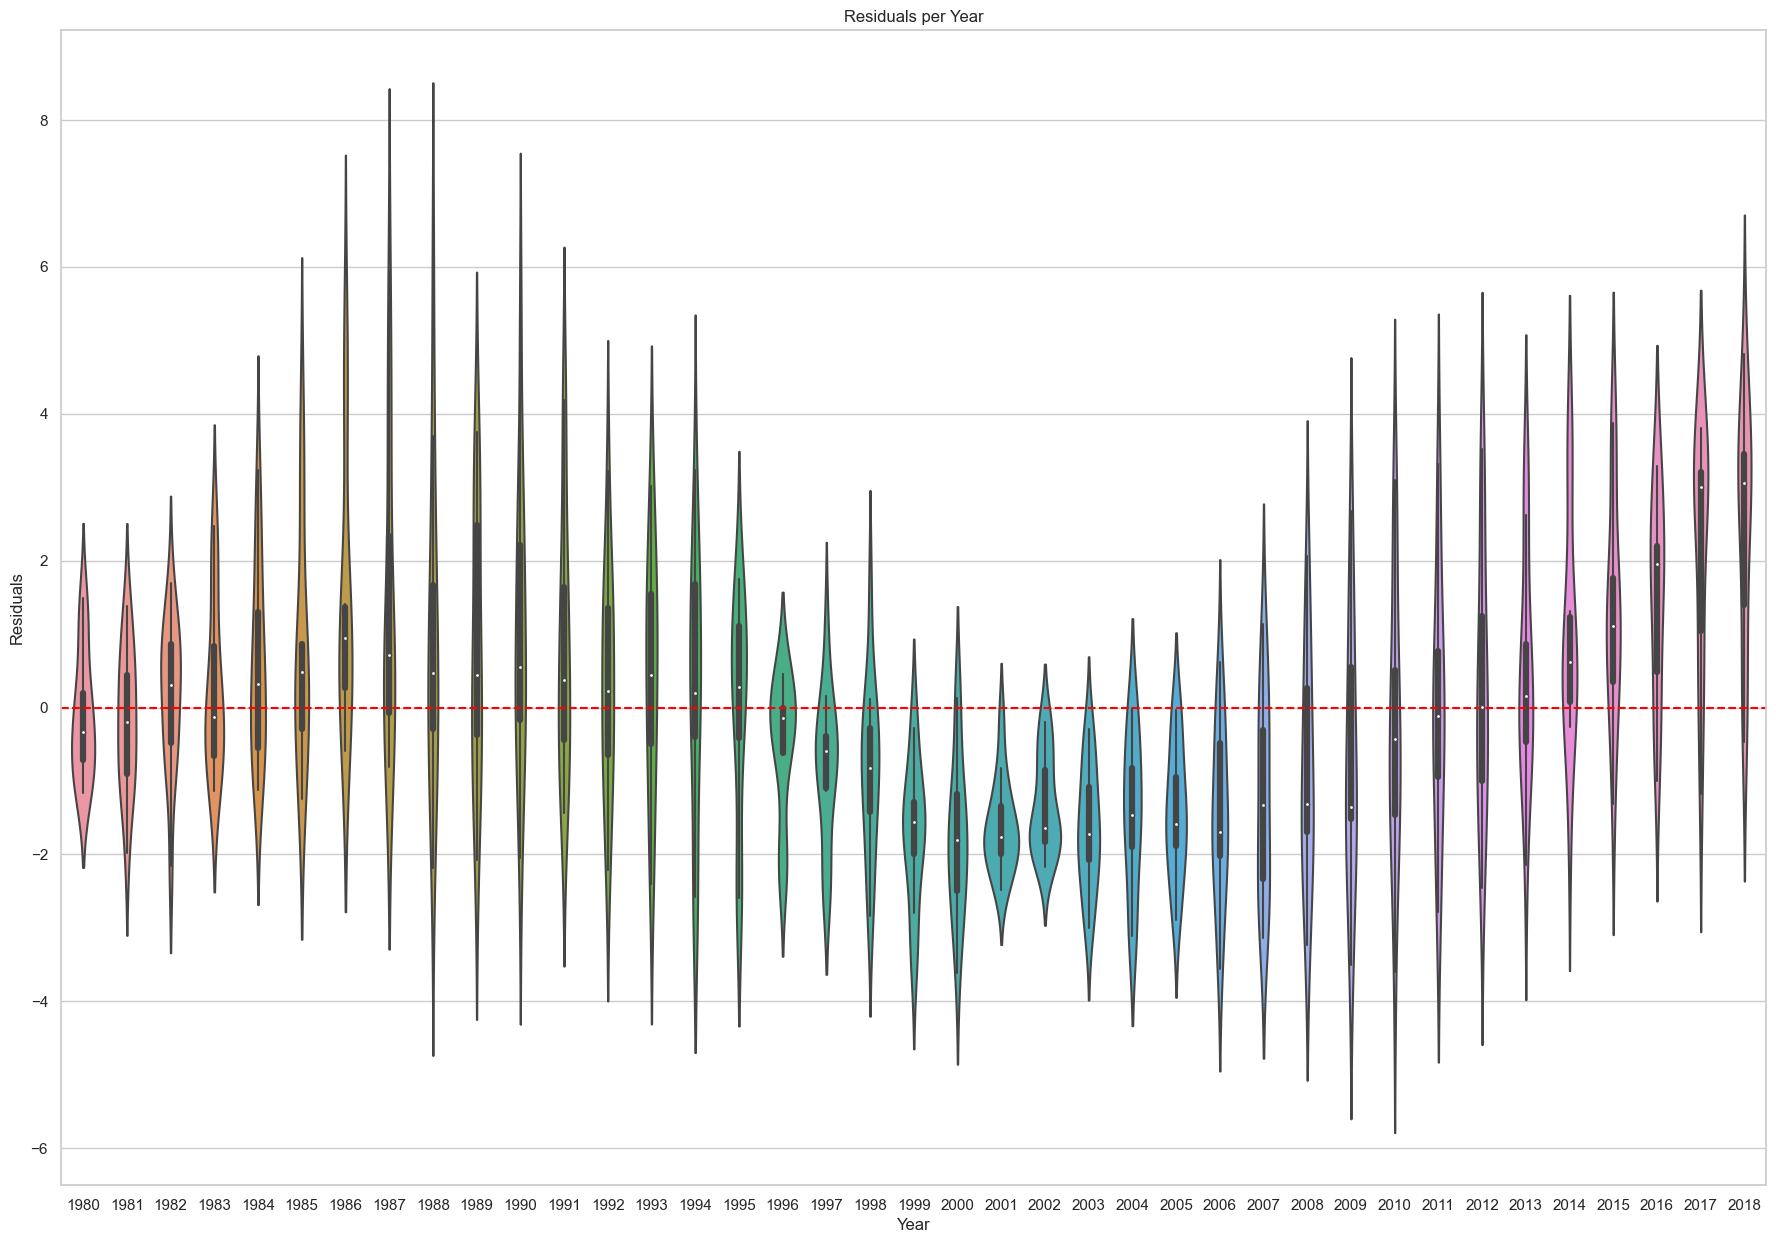

In [14]:
# Add residuals to the data
residuals = model.resid
filtered_df['residuals'] = residuals

# Create a violin plot of the residuals per year
plt.figure(figsize=(22,15))
sns.violinplot(x='YEAR', y='residuals', data=filtered_df)
plt.xlabel('Year')
plt.ylabel('Residuals')
plt.title('Model Residuals vs. Year')
plt.axhline(y=0, color='red', linestyle='--') # Center Line
plt.show()

Looking at the plot of the risiduals versus time, you can clearly see a sort of sine wave pattern through the years. This would indicate that there are more factors involved with changing suicide rate, which is almost certain for such a complex thing. Factors like gender, economic state, sub location (where inside of the United States), etc, could all be playing a variable role, not just noise like single-time events might have.

I think it's also interesting that we see a steady climb in all groups post 2001. To me this suggests that there are factors that have risen recently that have affected every group, regardless of age especially (since we just isolated it). To me, even without economic data, I feel this could be caused by social media and the proliferation of easy-access technology/internet, including but not limited to cyber bulllying, societal expectations, addiction, etc.


In [15]:
print("F-statistic 1:", model.fvalue)
print("P-value 1:", model.f_pvalue)
print("R-Squared:",model.rsquared)

F-statistic 1: 232.5699014154761
P-value 1: 6.381167753594247e-216
R-Squared: 0.8597826781431085


Looking at the statistics for the learning results, we see that age is definitely a statistically significant factor on how suicide rates have changed over the years. The R-Squared score suggests that age is a sigificant factor, but is not entirely encompassing, which makes sense as other personal factors are definitely contributers.

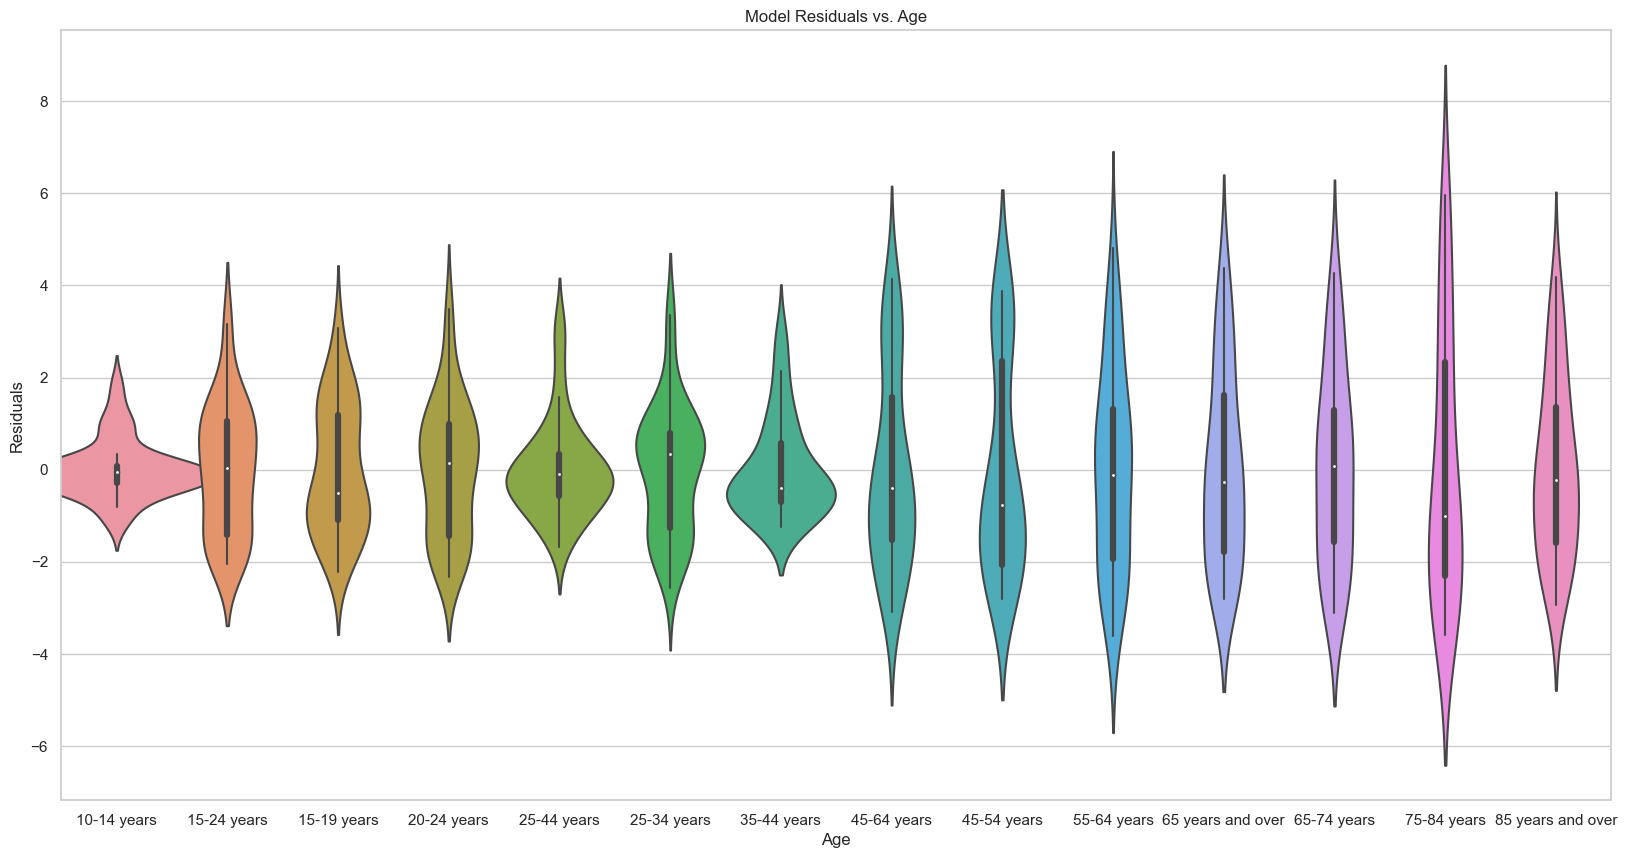

In [16]:
plt.figure(figsize=(20, 10))
sns.violinplot(x='AGE', y='residuals', data=filtered_df, width=1.8, aspect=1.5)
plt.xlabel('Age')
plt.ylabel('Residuals')
plt.title('Model Residuals vs. Age')
plt.show()

When we look at the risiduals for age, we see that most groups are close to zero, however older groups vary a lot, which could speak to gender/race/other factors contributing specifically to those age groups. For example, social norms and expectations that people may have held before that would affect men/women/certain races asymetrically would cause a split in the violin plots, or generalized stretching, where groups unaffected will show up as lower, and targeted groups would show higher. A lower/higher average could either be noise or due to other contributing factors like I explained before

<Figure size 2000x1000 with 0 Axes>

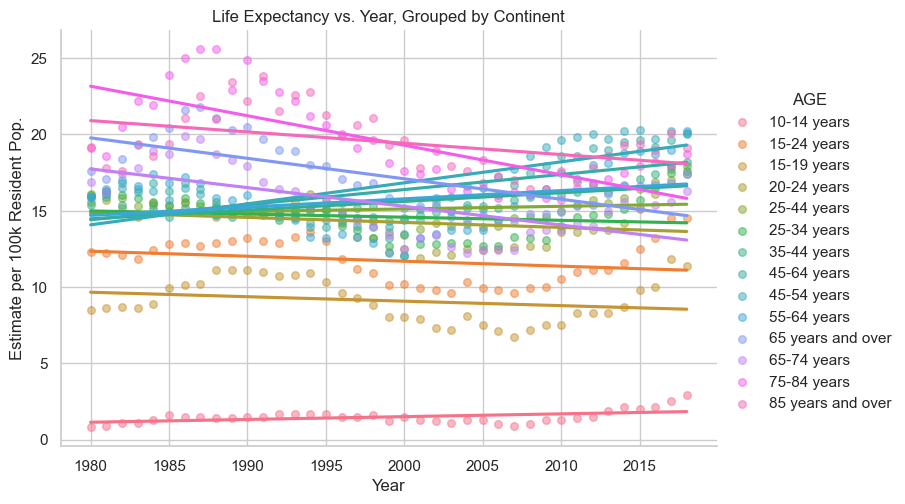

In [17]:
plt.figure(figsize=(20, 10))
sns.lmplot(x='YEAR', y='ESTIMATE', hue='AGE', data=filtered_df, ci=None, scatter_kws={'s': 30, 'alpha': 0.5}, aspect=1.5)
plt.xlabel('Year')
plt.ylabel('Estimate per 100k Resident Pop.')
plt.title('Life Expectancy vs. Year, Grouped by Age Group')
plt.show()

Here is a plot of a linear regression for each group individually. Note that a lot of the very old groups (65+) see a general decline in suicide rate, while the middle-aged (35-55) groups see a general increase, and young groups are estimated as neutral. However, it is important to note that this linear trend is not a good approximation overall for many groups, in my opinion, as you can see clear patterns in the younger groups of a general increase starting from ~2008.

### Interpretation
Overall, the general consensus is that suicide rates have been changing throughout the years, and appear on track to increase as time goes on given the trends from the data. This is evident by all groups experiencing an upward trend after a similarly general dive around 2000. A major factor in separating suicide rates is age, where certain age groups have been affected in different ways, where some groups have much different parameters for how their rates are expressed, such as younger groups having a significantly lower rate than middle and older groups.

The data suggest that there are other factors that contribute to suicide rates, some are likely to be time-related like major events happening or social norm changes over time, and others are likely due to personal factors such as gender, race, economic status, the status of the person's parents, etc. Given more concrete data with many potential factors being accounted for, analysis could be ran similar to my analysis of age, where contributing factors could be identified.

Overall, I think it is important that we are aware of the situation, and which groups to look out for the most in order to help everyone of course, but also potentially identify those who are most at risk, where ideally pre-meditated help or assistance could be offered to help people who may be or may become suicidal.